In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers, models
from keras.utils import load_img, img_to_array
from matplotlib import pyplot as plt
import os
import re
import pandas as pd
from collections import defaultdict
import matplotlib.colors as mcolors

#functions that converts string with hexadecimal color in 24-bit rgb space into array of integers corresponding to the input
#example:
#a = hex_to_rgb("ff0000")
#print(a)
#[255,0,0]
def hex_to_rgb(hex_color):
    return [int(hex_color[i:i+2], 16)/255.0 for i in (0, 2, 4)]

#function used in conversion from rgb and lab color space
def f(t):
    delta = 6/29
    return np.where(t > delta**3, np.cbrt(t), (t / (3 * delta**2)) + (4/29))
#function used in conversion from lab and rgb color space
def inv_f(t):
    delta = 6/29
    return np.where(t > delta, t**3, 3 * delta**2 * (t - 4/29))
#inversion of gamma correction function
def inv_gamma_correct(c):
    return np.where(c <= 0.0031308, 12.92 * c, 1.055 * np.power(c, 1/2.4) - 0.055)
#function normalizes color in lab space
#l_in = <0;100>
#a_in = <-127;128>
#b_in = <-127;128>
#l_out,a_out,b_out = <0;1>
def lab_normalize(lab):
    return (lab + np.array([0, 128, 128])) / np.array([100, 255, 255])
#function takes normalized lab values and returns denormalized values
def lab_unnorm(lab):
    return lab * np.array([100, 255, 255]) - np.array([0, 128, 128])
#function takes denormalized lab values and returns normalized rgb
def lab_to_rgb(lab):
    L, a, b = lab
    fy = (L + 16) / 116
    fx = fy + a / 500
    fz = fy - b / 200
    xyz = np.array([
        0.95047 * inv_f(fx),
        1.00000 * inv_f(fy),
        1.08883 * inv_f(fz)
    ])
    rgb_lin = np.array([
        3.2406 * xyz[0] - 1.5372 * xyz[1] - 0.4986 * xyz[2],
        -0.9689 * xyz[0] + 1.8758 * xyz[1] + 0.0415 * xyz[2],
        0.0557 * xyz[0] - 0.2040 * xyz[1] + 1.0570 * xyz[2]
    ])
    rgb = inv_gamma_correct(np.clip(rgb_lin, 0, 1))
    return np.clip(rgb, 0, 1)
#function takes an array of normalized rgb values and returns string that represents this color in hex
#example:
#in = [0,0,1]
#print(rgb_to_hex(in))
#"#0000ff"
def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))
#function converts from normalized rgb to lab color space and stacks those values into one array
def convert_lab(image):
    mask = image > 0.04045
    img_linear = np.where(mask, ((image + 0.055) / 1.055) ** 2.4, image / 12.92)
    R, G, B = img_linear[..., 0], img_linear[..., 1], img_linear[..., 2]
    X = (0.4124564 * R + 0.3575761 * G + 0.1804375 * B) / 0.950489
    Y = (0.2126729 * R + 0.7151522 * G + 0.0721750 * B) / 1.0
    Z = (0.0193339 * R + 0.1191920 * G + 0.9503041 * B) / 1.088840
    X, Y, Z = f(X), f(Y), f(Z)
    L = 116.0 * Y - 16.0
    a = 500.0 * (X - Y)
    b = 200.0 * (Y - Z)
    return np.stack([L, a, b], axis=-1)

#function reads data from Res_ColorPickerCustomPicker/ with user choice describing the pictures and returns a dataframe with file from where the data is from, image, and selected colors
#example row
#file='AdrianR_2025_03_20-13_05_22.txt', image='000000010432', color_1 = ['0000ff'], color_2 = ['0000ff','00ff00'], color_3= ['0000ff','00ff00','ff0000'], ...
def make_dataset():
    basedir = "Data/Res_ColorPickerCustomPicker"
    rows = []

    for file in os.listdir(basedir):
        filepath = os.path.join(basedir, file)
        if re.match(r".*\d{2}\.txt", file):
            image_groups = defaultdict(list)  # key: image filename, value: list of color groups

            with open(filepath, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if not parts:
                        continue
                    image = parts[0]
                    colors = [c.strip(",").replace('#', '') for c in parts[1:]]
                    image_groups[image].append(colors)

            # Now for each image in this file, pad its color groups and add to the rows
            for image, color_groups in image_groups.items():
                while len(color_groups) < 5:
                    color_groups.append([])

                rows.append({
                    'file': file,
                    'image': image,
                    'color_1': color_groups[0],
                    'color_2': color_groups[1],
                    'color_3': color_groups[2],
                    'color_4': color_groups[3],
                    'color_5': color_groups[4],
                })

    return pd.DataFrame(rows)


#function splits array into a tuple
def hex_to_rgb_tuple(hex_color):
    return mcolors.to_rgb(hex_color)

2025-06-27 19:21:46.935179: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-27 19:21:47.059958: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-27 19:21:47.098442: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751044907.137863  178526 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751044907.148596  178526 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751044907.183304  178526 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
#number of colors that are being predicted be neural network
input_colors = 5
#directory where the pictures are stored
basedir = "Data/PhotosColorPicker/"

df = make_dataset()
#extend dataframe by a column with path to each picture
df['image_path'] = basedir + df['image']
#function to load pictures and convert colors from rgb to normalized lab
def load_image(path):
    img = load_img(path, target_size=(128, 128))
    rgb_norm = img_to_array(img) / 255.0
    lab = convert_lab(rgb_norm)
    return lab_normalize(lab)

#group colors by image and collect them into one array for number of selected colors
b = df.groupby(df['image']).sum()
b = b[['color_1','color_2','color_3','color_4','color_5']]
b = b.reset_index()
b['image_path'] = basedir + b['image']
from sklearn.cluster import KMeans

#convert strings to corresponding rgb values
for c in range(1,6):
    b[f"norm_rgb_{c}"] = b[f'color_{c}'].apply(lambda a : [hex_to_rgb(str(i)) for i in a])
#convert to lab
for c in range(1,6):
    b[f"lab_{c}"] = b[f'norm_rgb_{c}'].apply(lambda a : [convert_lab(np.array(i)) for i in a])
#normalize lab values
for c in range(1,6):
    b[f"norm_lab_{c}"] = b[f'lab_{c}'].apply(lambda a : [lab_normalize(np.array(i)) for i in a])
#function to make n clusters where n is numbers of colors predicted be neural network, used to find colors chosen by users. Middle of the cluster is selected as the truth
def cluster_image_colors(color_vectors, n_clusters=5):
    # Convert to numpy array
    color_array = np.array(color_vectors)

    # Handle edge cases: if fewer vectors than clusters
    if len(color_array) < n_clusters:
        return color_array  # Just return raw vectors

    # Apply KMeans
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(color_array)

    return kmeans.cluster_centers_

#cluster colors, with normalized lab values
b['color_palette_lab'] = b[f'norm_lab_{input_colors}'].apply(lambda x: cluster_image_colors(x, n_clusters=input_colors))
#convert the truths into rgb format
b["color_paletter_rgb"] = b['color_palette_lab'].apply(
    lambda palette: [lab_to_rgb(lab_unnorm(color)) for color in palette]
)
c = b["color_paletter_rgb"]

#load images and create datasets for nn training

image_tensors = tf.stack([load_image(path) for path in b['image_path']])
labs = np.stack(b['color_palette_lab'].values)
labels = np.array(labs.astype(np.float64)).reshape(-1, 3*input_colors)

dataset = tf.data.Dataset.from_tensor_slices((image_tensors, labels)).shuffle(buffer_size=len(image_tensors))
#split dataset in 20/80 proportion for training and validation
val_size = int(0.2 * len(image_tensors))
train_dataset = dataset.skip(val_size).batch(32)
val_dataset = dataset.take(val_size).batch(32)

2025-06-27 19:21:55.165771: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [14]:
#model definition
model = models.Sequential([
    layers.Input(shape=(128, 128, 3)),
    layers.Conv2D(16 * input_colors, (3, 3), activation='relu'),
    layers.AveragePooling2D(2, 2),

    layers.Conv2D(32 * input_colors, (3, 3), activation='relu'),
    layers.AveragePooling2D(2, 2),

    layers.Conv2D(64 * input_colors, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(3 * input_colors, activation='sigmoid')
])

#learing
model.compile(optimizer=tf.keras.optimizers.Adam(amsgrad=True, learning_rate=1e-3), loss="mse")
history = model.fit(train_dataset, epochs=50, validation_data=val_dataset)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 369ms/step - loss: 0.1015 - val_loss: 0.0489
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step - loss: 0.0434 - val_loss: 0.0358
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 345ms/step - loss: 0.0348 - val_loss: 0.0308
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step - loss: 0.0339 - val_loss: 0.0332
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step - loss: 0.0340 - val_loss: 0.0348
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step - loss: 0.0330 - val_loss: 0.0335
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 354ms/step - loss: 0.0341 - val_loss: 0.0334
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 342ms/step - loss: 0.0321 - val_loss: 0.0338
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 354ms/step - loss: 0.0327 - val_loss: 0.0301
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 347ms/step - loss: 0.0317 - val_loss: 0.0297
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 340ms/step - loss: 0.0304 - val_loss: 0.0338
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 356ms/step - loss: 0.0296 - val_lo

In [15]:
#validation
def mae(predictions, truth):
    return np.mean(np.abs(predictions - truth))

def rmse(predictions, truth):
    return np.sqrt(np.mean((predictions - truth)**2))

def safe_compare(predictions, truth):
    eps = 1e-6
    return np.mean(np.abs(predictions - truth) / (np.abs(truth) + eps), axis=0)

#make predictions and calculate some values to evaluate model
all_preds = model.predict(tf.data.Dataset.from_tensor_slices(image_tensors).batch(32))
val_predicts = model.predict(val_dataset)
print("Compare %:", safe_compare(val_predicts, labels[:len(val_predicts)]) * 100)
print("MAE:", mae(val_predicts, labels[:len(val_predicts)]))
print("RMSE:", rmse(val_predicts, labels[:len(val_predicts)]))

#print first 5 predicted colors and truths
for i in range(5):
    p = (((val_predicts[i])))
    t = ((labels[i]))
    print("Predicted:", rgb_to_hex(p), "True:", rgb_to_hex(t))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Compare %: [1.46890584e+02 2.55120029e+01 4.57523102e+01 1.21326630e+02
 1.14367846e+01 2.74383872e+01 7.59795784e+01 1.93701510e+01
 3.94085755e+01 4.69569991e+06 2.05447548e+01 2.33076206e+01
 8.22147805e+01 2.44770191e+01 3.43127197e+01]
MAE: 0.18162349804034492
RMSE: 0.2463453076988366
Predicted: #b9738e True: #f37e7e
Predicted: #a6b1a9 True: #849f62
Predicted: #667798 True: #a36e94
Predicted: #d79184 True: #8f8f71
Predicted: #1f7478 True: #59bd25


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted color: ['#949e4b', '#7487a4', '#86b7ae', '#3e436f', '#b1607f']
True color: ['#9969af', '#c8362f', '#4432b0', '#9eeb70', '#b3bab8']


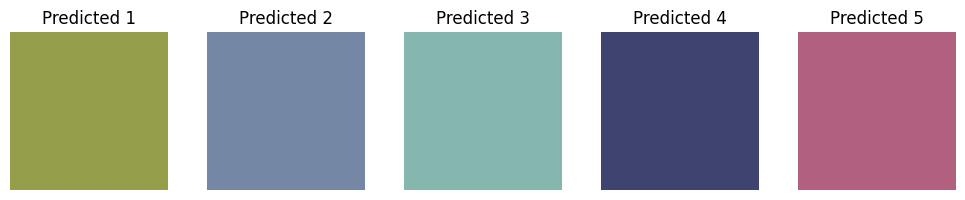

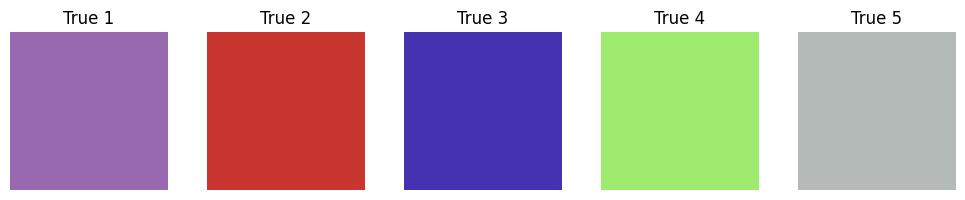

In [20]:
#load pretrained model or use the trained one
#model = keras.saving.load_model("model_5_colors.keras")

#function to display colors
def show_colors(hex_list, titles=None):
    fig, ax = plt.subplots(1, len(hex_list), figsize=(len(hex_list) * 2, 2))
    if len(hex_list) == 1:
        ax = [ax]
    for i, hex_color in enumerate(hex_list):
        rgb = np.array([[hex_to_rgb_tuple(hex_color)]])
        ax[i].imshow(rgb)
        ax[i].axis("off")
        if titles:
            ax[i].set_title(titles[i])
    plt.tight_layout()
    plt.show()
#file name
file = "000000014824.jpg"
#image path
image_path = f"Data/PhotosColorPicker/{file}"

#load file and convert to normalized lab
image = load_img(image_path, target_size=(128, 128))
img_array = img_to_array(image) / 255.0
lab_image = convert_lab(img_array)
lab_normed = lab_normalize(lab_image)
input_arr = np.expand_dims(lab_normed, axis=0)
#make prediction
prediction = model.predict(input_arr).reshape(input_colors,3)
#convert from lab to rgb
lab_pred = [lab_unnorm(i) for i in prediction]
rgb_pred = [lab_to_rgb(i) for i in lab_pred]
pred_hex = [rgb_to_hex(i) for i in rgb_pred]
#get truths from dataset
true_rgb = [i for i in b[b['image'] == file]["color_paletter_rgb"].iloc[0]]
true_hex = [rgb_to_hex(i) for i in true_rgb]
#display comparison between prediction and truths
print("Predicted color:", pred_hex)
print("True color:", true_hex)
titles = [f"Predicted {i+1}" for i in range(len(pred_hex))]
show_colors(pred_hex, titles)
titles = [f"True {i+1}" for i in range(len(true_hex))]
show_colors(true_hex, titles)

In [ ]:
#make a graph off loss function over epochs
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()